# Data collecting of the occupancy detector 
For record the occupancy in the office zone, an occupancy detector is introduced.

The infrared array sensor grid-eye unit is AMGU 4241, produced by Panasonic.

The electric specifications follows RS-485 and the protocol is Modbus-RTU.

We use Raspberry Pi as data logger and conduct the signal connection through python.

Here share the code and the datasheet of the device can refer to the link at the bottom.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from pymodbus.client.sync import ModbusSerialClient
import sqlite3
from scipy.interpolate import griddata
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

### Connect the device
Record the data by connecting to the device's signal.

Store the data in a db file.

In [2]:
def get_data():
    Time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # Set protocol parameters
    client = ModbusSerialClient(method='rtu', port='/dev/ttyUSB0', baudrate=38400, parity='O', bytesize=8, stopbits=1)
    response = client.read_holding_registers(address=0x0000, count=7, unit=0x01)
    res = response.registers
    # get occupancy
    src = res[0]
    Occ = src
    # get positions
    src = res[1]
    Pos1 = src
    src = res[2]
    Pos2 = src
    # get existence
    src = res[3]
    Exist = src
    # get moving direction
    src = res[4]
    Dir1 = src
    src = res[5]
    Dir2 = src
    # get surface Temp.
    src = res[6]
    src = round(src/256, 2)
    Temp = src
    
    data = pd.DataFrame(dict(
        Time = [Time],
        Temp = [Temp],
        Occ = [Occ],
        Pos1 = [Pos1],
        Pos2 = [Pos2],
        Exist = [Exist],
        Dir1 = [Dir1],
        Dir2 = [Dir2]))
    return data

# data_log = get_data()
# conn = sqlite3.connect(r'C:\Users\Jacky\Jupyter Projects\Occupancy_Prediction\Data\get_AMGU.db')
# cursor = conn.cursor()    
# data_log.to_sql('sensor_log', con=conn, if_exists='append')

**Note: Use a loop function can record the data continuously.

### Import raw data
Choose an example from database for grid data analysis.

In [3]:
conn = sqlite3.connect(r'C:\Users\Jacky\Jupyter Projects\Occupancy_Prediction\Data\get_AMGU.db')
start = "2020-10-07 14:05"
end = "2020-10-07 14:07"
sql_read = F"SELECT * FROM sensor_log WHERE Time BETWEEN '{start}' AND '{end}'"
pp_rawdata = pd.read_sql(sql=sql_read, con=conn)
conn.close()
pp_rawdata.drop(['index'], axis=1)

,Time,Occ,Pos1,Pos2,Exist,Dir1,Dir2,Temp
0,2020-10-07 14:05:02,2,29696,0,36864,0,0,21.59
1,2020-10-07 14:06:02,3,29708,0,36880,10,0,21.63


### Plot the position figure
The raw data is transferred into the grid frame and plotted as a heatmap to present the human position.

The blue polygons represent the desks and chairs in the office.

The bright color blocks represent human occupancy. 

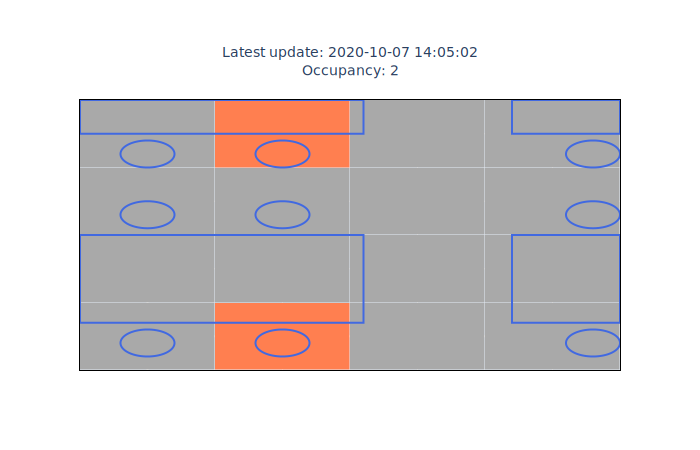

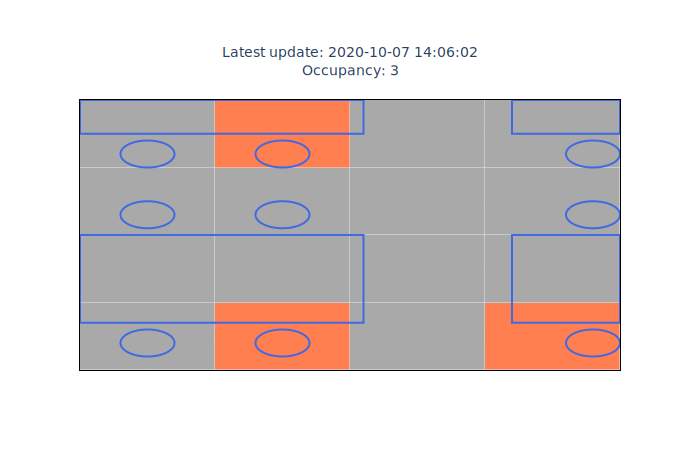

In [4]:
for i in range(len(pp_rawdata)):
    # People Position
    src = pp_rawdata['Exist'][i]
    src = np.asarray(src, dtype = "uint16")
    src = np.frombuffer(src, dtype = "uint8")
    src = np.unpackbits(src, bitorder = 'little')
    pp = list(src)

    # Transfer into Grid Data
    x = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
    y = [2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1]
    Pos = [(x[j], y[j]) for j in range(16)]
    grid_x, grid_y = np.mgrid[0:3:4j, 0:3:4j]
    PPCub = griddata(Pos, pp, (grid_x, grid_y), method='cubic')
    
    # Plot
    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(
            z=PPCub,
            xgap=0.5,ygap=0.5,
            colorscale=[[0, "darkgray"],[1, "coral"]],
            showscale=False,
            colorbar=dict(
                x=1.1,
                tick0=0, dtick=1, tickvals=[0,1], ticktext=['Unoccupied','Occupied'],
                lenmode="pixels"),
            showlegend=False))
    tt = pp_rawdata['Time'][i]
    occ = pp_rawdata['Occ'][i]
    
    xis_template = dict(
        range = [-0.5,3.5], 
        showgrid = True, 
        linecolor = 'black', mirror=True, showticklabels = False,
        title=F'Latest update: {tt} <br> Occupancy: {occ}', side='top')
    axis_template = dict(
        range = [-0.5,3.5], 
        showgrid = True, 
        linecolor = 'black', mirror=True, showticklabels = False)
    fig.update_layout(
        width = 500, height = 500, autosize = False, xaxis = xis_template, yaxis = axis_template,
        shapes=[dict(type="circle",x0=-.2,y0=2,x1=.2,y1=1.6,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=.8,y0=2,x1=1.2,y1=1.6,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=-.2,y0=2.9,x1=.2,y1=2.5,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=.8,y0=2.9,x1=1.2,y1=2.5,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=-.2,y0=.1,x1=.2,y1=-.3,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=.8,y0=.1,x1=1.2,y1=-.3,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=3.1,y0=2,x1=3.5,y1=1.6,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=3.1,y0=2.9,x1=3.5,y1=2.5,line=dict(color="RoyalBlue")),
                dict(type="circle",x0=3.1,y0=.1,x1=3.5,y1=-.3,line=dict(color="RoyalBlue")),
                dict(type="rect",x0=-.5,y0=.2,x1=1.6,y1=1.5,line=dict(color="RoyalBlue")),
                dict(type="rect",x0=-.5,y0=3,x1=1.6,y1=3.5,line=dict(color="RoyalBlue")),
                dict(type="rect",x0=2.7,y0=.2,x1=3.5,y1=1.5,line=dict(color="RoyalBlue")),
                dict(type="rect",x0=2.7,y0=3,x1=3.5,y1=3.5,line=dict(color="RoyalBlue")),])
    fig.update_yaxes(tickvals=[0,1,2,3])
    fig.show()

As we can see during the period of the example, there is an occupant moving into the office and sitting on the right bottom.

Moreover, the data will be recorded as an occupancy feature for other applications in the office.

**Note: The figure size is not in the best one because Github can't show a plotly figure.

### Reference

[1]

AMGU 4241 <br>
https://na.industrial.panasonic.com/whats-new/infrared-array-sensor-grid-eye-unit-amgu4241